# Importing libraries

- ` time ` for giving the processing time
- `psutil` for showing the memory we are using
- `multiprocessing` for showing the cores count
- `sys` to control the system
- `warnings` to supress the system warnings
- `numpy` & `pandas` data preproessing libraries
- `sklearn` for building ML models and other data preprocessing


In [1]:
# loading the required packages
import time
import psutil
import multiprocessing as mp

# system & general libraries
import sys
import warnings
warnings.filterwarnings('ignore')
sys.setrecursionlimit(1000000)

# pre-processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# imputation libraries

from impyute.imputation.cs import mice
from impyute.imputation.cs import fast_knn
from missingpy import MissForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# check the number of cores & memory usage
num_cores = mp.cpu_count()
print("this kernel has "+str(num_cores)+" cores")
print("memory usage :",psutil.virtual_memory())

this kernel has 4 cores
memory usage : svmem(total=17066516480, available=7895769088, percent=53.7, used=9170747392, free=7895769088)


In [3]:
# importing the data
Accidents = pd.read_csv('./Accident_Information.csv')
# Vehicles = pd.read_csv('./Vehicle_Information.csv', encoding='ISO-8859-1')
# for checking the virtual memory available
print("memory usage after importing data :\n\n",psutil.virtual_memory())

memory usage after importing data :

 svmem(total=17066516480, available=7178313728, percent=57.9, used=9888202752, free=7178313728)


In [4]:
# glimpse of the dataset
Accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 34 columns):
Accident_Index                                 object
1st_Road_Class                                 object
1st_Road_Number                                float64
2nd_Road_Class                                 object
2nd_Road_Number                                float64
Accident_Severity                              object
Carriageway_Hazards                            object
Date                                           object
Day_of_Week                                    object
Did_Police_Officer_Attend_Scene_of_Accident    float64
Junction_Control                               object
Junction_Detail                                object
Latitude                                       float64
Light_Conditions                               object
Local_Authority_(District)                     object
Local_Authority_(Highway)                      object
Location_Easting_OS

In [5]:
# glimpse of dataset
# Vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177205 entries, 0 to 2177204
Data columns (total 24 columns):
Accident_Index                      object
Age_Band_of_Driver                  object
Age_of_Vehicle                      float64
Driver_Home_Area_Type               object
Driver_IMD_Decile                   float64
Engine_Capacity_.CC.                float64
Hit_Object_in_Carriageway           object
Hit_Object_off_Carriageway          object
Journey_Purpose_of_Driver           object
Junction_Location                   object
make                                object
model                               object
Propulsion_Code                     object
Sex_of_Driver                       object
Skidding_and_Overturning            object
Towing_and_Articulation             object
Vehicle_Leaving_Carriageway         object
Vehicle_Location.Restricted_Lane    float64
Vehicle_Manoeuvre                   object
Vehicle_Reference                   int64
Vehicle_Type            

# Forecasting problem


In [5]:
# useful functions
def test_stationarity(Acc_dt):
    print('Results of Dickey-Fuller test :')
    dftest = adfuller(Acc_dt, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## 1. pre-processing

In [6]:
# pre-processing
# converting the date column
Accidents['Date'] = pd.to_datetime(Accidents['Date'], format = '%Y-%m-%d')
# setting date as index
Accidents.set_index(Accidents['Date'], inplace = True)

# classes of accidents
acc_classes = Accidents['Accident_Severity'].unique()
print("various classification of accidents :\n")
[print(i) for i in acc_classes]
print("\n")

various classification of accidents :

Serious
Slight
Fatal




## 2. Visualization

Serious


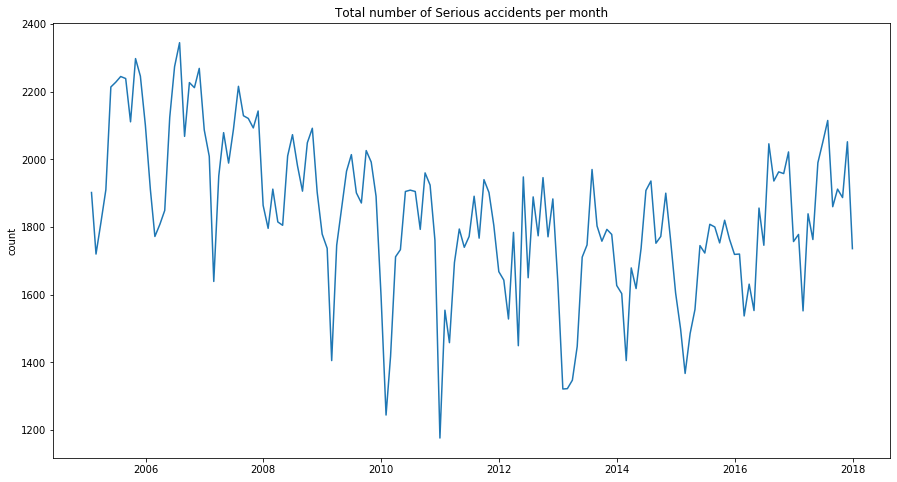

Slight


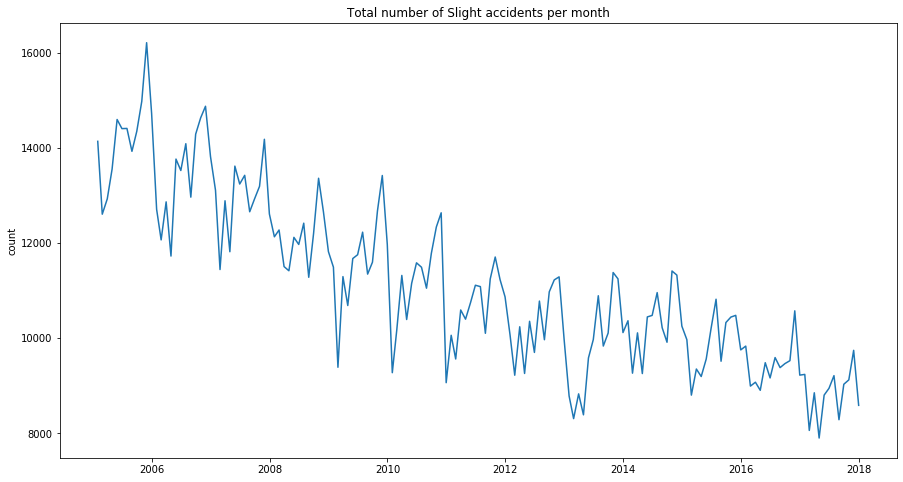

Fatal


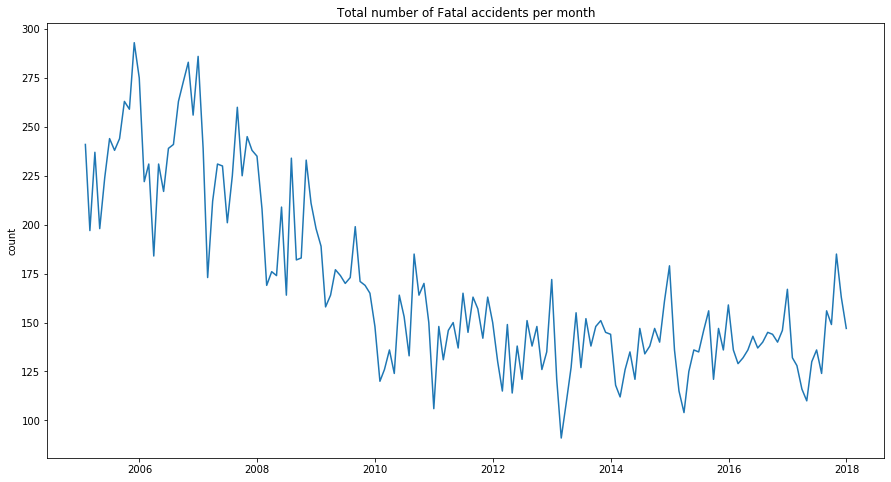

In [7]:
for acc_type in acc_classes:
    print(acc_type)
    plt.figure(figsize = (15,8))
    plt.plot(Accidents[Accidents['Accident_Severity'] == acc_type].resample('M').size())
    plt.title("Total number of "+acc_type+" accidents per month")
    plt.ylabel("count")
    plt.show()

## 3. Modeling

It consists of following steps
1. checking for **stationarity** of a time-series signal.
2. If it is not stationary, we try to remove the trend and seasonality to make the series stationary
3. Checking for stationarity can be done using `Dickey Fuller test`.
4. Trend can be removed in :
    - **Smoothing** : taking rolling average.
    - **Polynomial fit**

Total accidents 


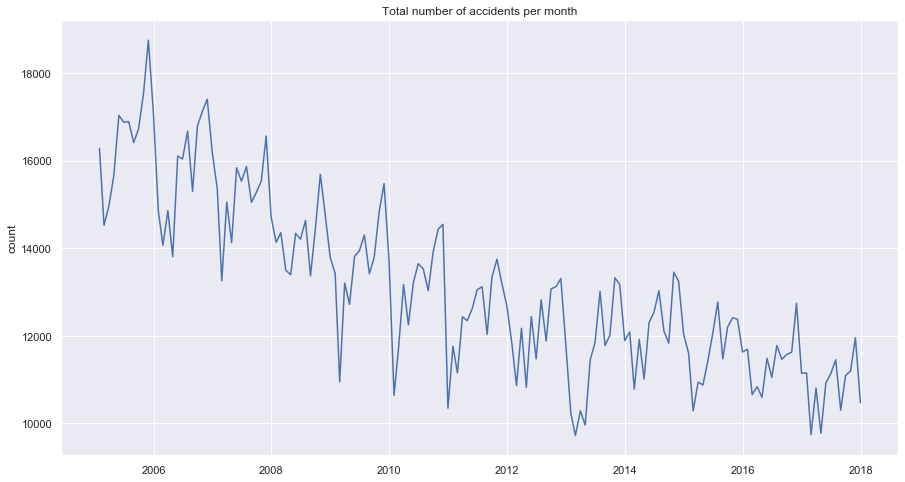

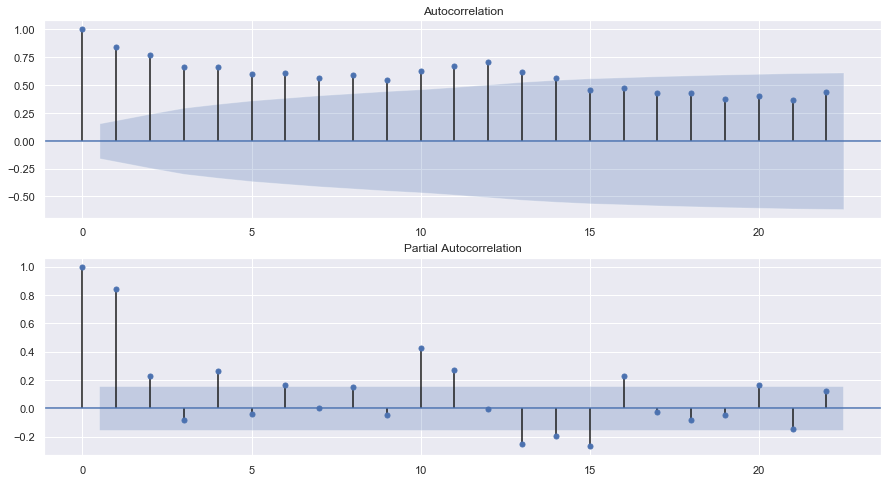

Results of Dickey-Fuller test :
Test Statistic                  -1.815147
p-value                          0.372968
#Lags Used                      14.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64
The process is not stationary


In [8]:
# importing required libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import signal
import itertools

Acc_dt = Accidents.resample('M').size()
###3# Acc_dt.index > '2016-12-31'
# ACF of the data to decide the model to be fit
Acf = sm.tsa.stattools.acf(Acc_dt)

# visualizing
sns.set()
print("Total accidents ")
plt.figure(figsize = (15,8))
plt.plot(Accidents.resample('M').size())
plt.title("Total number of accidents per month")
plt.ylabel("count")
plt.show()

# ploting the acf and pacf
plt.figure(figsize = (15,8))
plt.subplot(211)
plot_acf(Acc_dt, ax = plt.gca())
plt.subplot(212)
plot_pacf(Acc_dt, ax = plt.gca())
plt.show()

# test for stationarity
print('Results of Dickey-Fuller test :')
dftest = adfuller(Acc_dt, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

# Result
print("The process is not stationary")

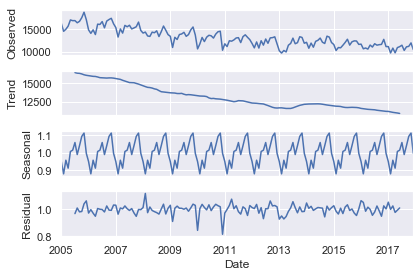

In [9]:
# decomposed plot
decomposition = sm.tsa.seasonal_decompose(Acc_dt, model = 'multiplicative')
decomposition.plot()
plt.show()

### Observation :
- It has a trend and seasonal component

Fitting trend using polynomial fit 


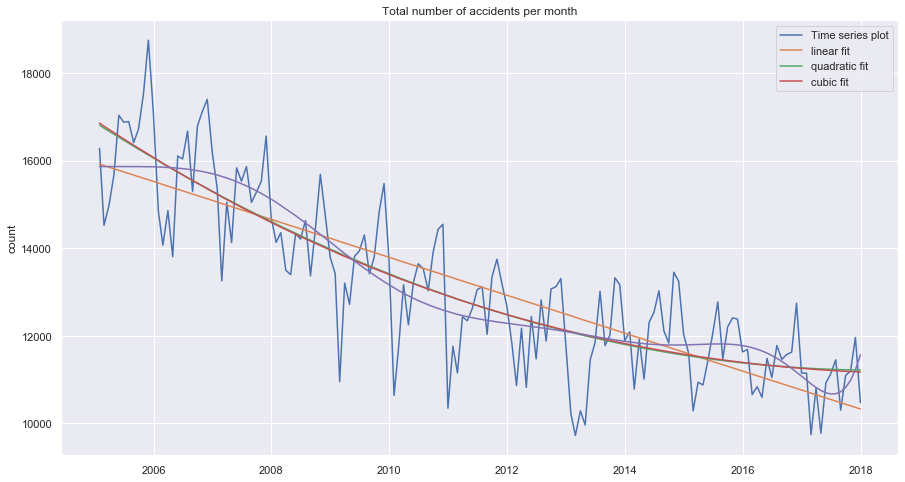

Fitting trend using rolling average of size 12


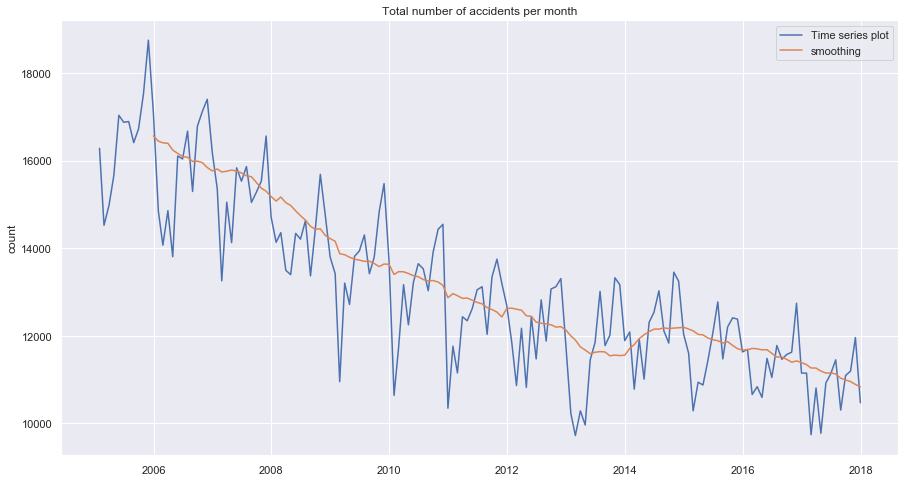

In [12]:
# fitting a trend
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as LR

# modeling
tvec = np.arange(0, len(Acc_dt)).reshape(-1,1)

poly2 = PolynomialFeatures(2)
poly3 = PolynomialFeatures(3)

# fitting linear trend # demonstration === underfit
lin_trend  = LR()
lin_trend.fit(tvec, Acc_dt)
linear = lin_trend.predict(tvec)

# fitting quadratic trend
deg_2_X = poly2.fit_transform(tvec)
quad_trend = LR()
quad_trend.fit(deg_2_X, Acc_dt)
quadratic = quad_trend.predict(deg_2_X)

# fitting cubic trend
deg_3_X = poly3.fit_transform(tvec)
cub_trend = LR()
cub_trend.fit(deg_3_X, Acc_dt)
cubic = cub_trend.predict(deg_3_X)

# fitting a 10th degree polynomial # overfit
poly10 = PolynomialFeatures(10)
deg_10_X = poly10.fit_transform(tvec)
deg_10_trend = LR()
deg_10_trend.fit(deg_10_X, Acc_dt)
deg_10_curve = deg_10_trend.predict(deg_10_X)

# choosing best fit trend
print("Fitting trend using polynomial fit ")
plt.figure(figsize = (15,8))
plt.plot(Accidents.resample('M').size(), label = 'Time series plot')
plt.plot(Acc_dt.index, linear, label = 'linear fit')
plt.plot(Acc_dt.index, quadratic, label = 'quadratic fit')
plt.plot(Acc_dt.index, cubic, label = 'cubic fit')
plt.plot(Acc_dt.index, deg_10_curve)
plt.title("Total number of accidents per month")
plt.legend()
plt.ylabel("count")
plt.show()

# fitting trend using moving average of window size = 12
moving_avg = Acc_dt.rolling(12).mean()
print("Fitting trend using rolling average of size 12")
plt.figure(figsize = (15,8))
plt.plot(Accidents.resample('M').size(), label = 'Time series plot')
plt.plot(Acc_dt.index, moving_avg, label = 'smoothing')
plt.title("Total number of accidents per month")
plt.legend()
plt.ylabel("count")
plt.show()

Residuals after removing the trend


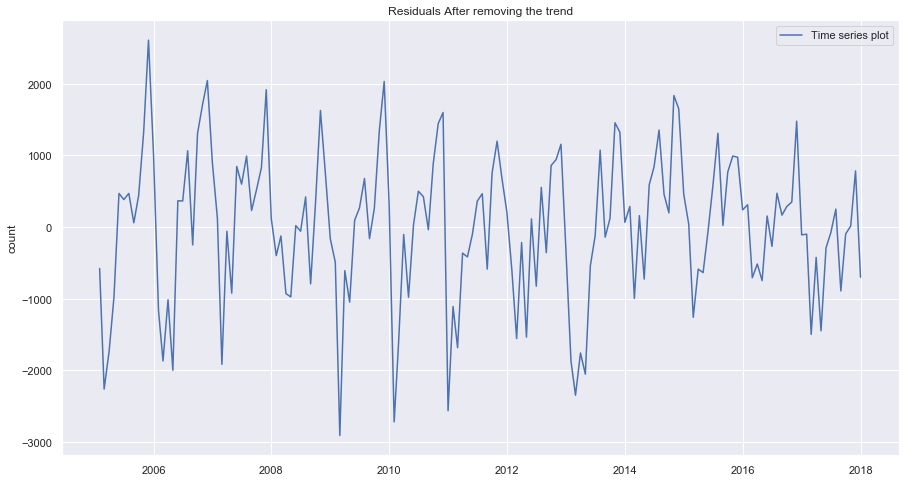

Seasonal and Random component after removing the trend (multiplicative model)


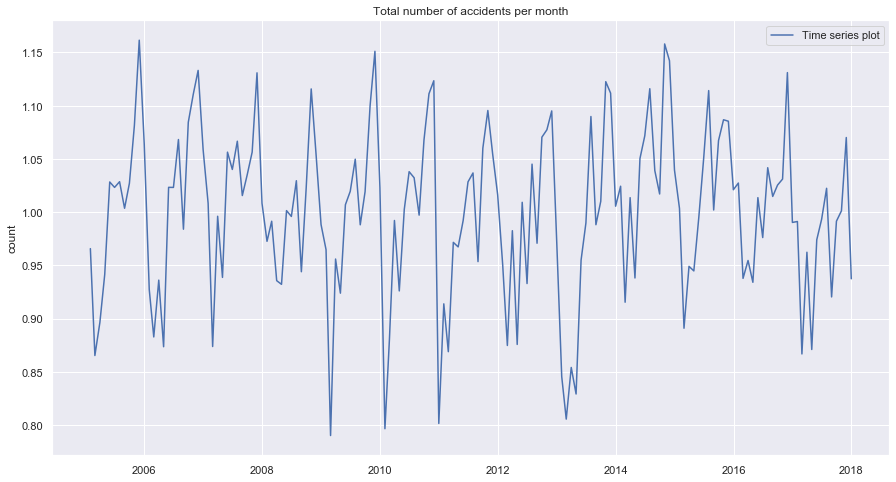

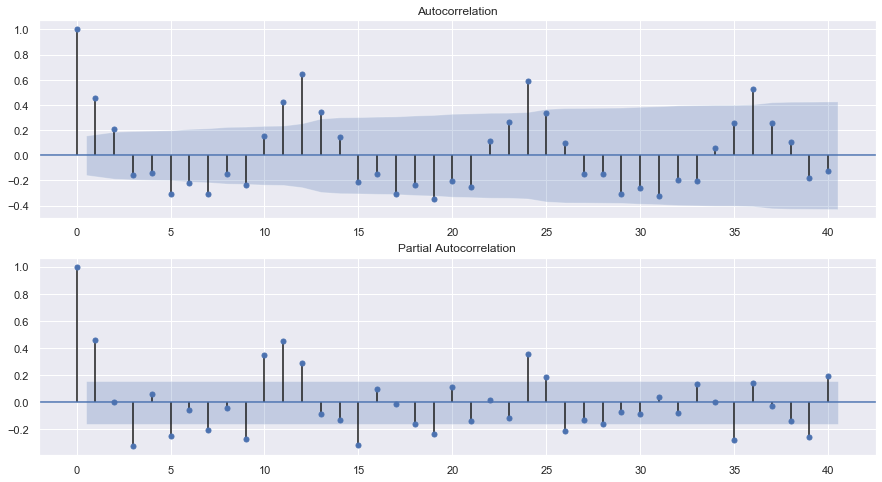

Periodogram


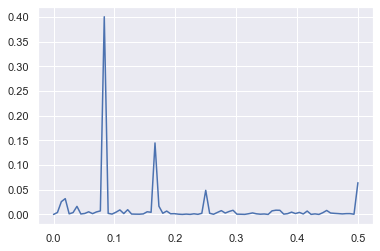

In [122]:
# data after removing trend
# we choose the polynomial of degree 3 for removing trend
# Multiplicative model, because it has varying amplitudes.
residuals = Acc_dt - cubic
print("Residuals after removing the trend")
plt.figure(figsize = (15,8))
plt.plot(residuals, label = 'Time series plot')
plt.title("Residuals After removing the trend")
plt.legend()
plt.ylabel("count")
plt.show()


Acc_dt_res = Acc_dt/cubic
# visualization 
print("Seasonal and Random component after removing the trend (multiplicative model)")
plt.figure(figsize = (15,8))
plt.plot(Acc_dt_res, label = 'Time series plot')
plt.title("Total number of accidents per month")
plt.legend()
plt.ylabel("count")
plt.show()

# ploting the acf and pacf
plt.figure(figsize = (15,8))
plt.subplot(211)
plot_acf(Acc_dt_res, ax = plt.gca(),lags = 40)
plt.subplot(212)
plot_pacf(Acc_dt_res, ax = plt.gca(), lags = 40)
plt.show()

# peridogram
print("Periodogram")
fs = 1
f, Pxx = signal.periodogram(Acc_dt_res, fs)
plt.plot(f, Pxx)
# plt.yticks(np.arange(0,1,100))
plt.show()

In [123]:
test_stationarity(Acc_dt_res)
print("Not stationary")


# KPSS test for trend stationarity
# print("\nKPSS test for trend stationarity\n")
# dftest = sm.tsa.stattools.kpss(results.resid)
# dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value','#Lags Used'])
# for key,value in dftest[3].items():
#     dfoutput['Critical Value (%s)'%key] = value
# print(dfoutput)
# print("\nFrom the p-value of KPSS test, there is further deterministic trend.")

Results of Dickey-Fuller test :
Test Statistic                  -2.424928
p-value                          0.134824
#Lags Used                      14.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64
Not stationary


In [112]:
# np.column_stack((np.cos(2*np.pi*0.1*tvec), np.sin(2*np.pi*0.1*tvec))).shape
# Acc_dt_res.shape
# tvec

In [113]:
# # fitting linear trend # demonstration === underfit
# lin_sin_trend  = LR()
# lin_sin_trend.fit(np.column_stack((np.cos(2*np.pi*0.1*tvec), np.sin(2*np.pi*0.1*tvec))), Acc_dt_res.values)
# linear_sin = lin_sin_trend.predict(np.column_stack((np.cos(2*np.pi*0.1*tvec), np.sin(2*np.pi*0.1*tvec))))

# Acc_dt_res = Acc_dt_res - linear_sin

# # ploting the acf and pacf
# plt.figure(figsize = (15,8))
# plt.subplot(211)
# plot_acf(Acc_dt_res, ax = plt.gca(),lags = 40)
# plt.subplot(212)
# plot_pacf(Acc_dt_res, ax = plt.gca(), lags = 40)
# plt.show()


## Observation:
- The ACF is periodic with a period of 12.
- So it has seasonal component.
- This can be confirmed from periodogram

In [124]:
# fitting SARIMA models of appropriate order
d = np.array([0])
p = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_order = pdq[0]
best_seas_order = seasonal_pdq[0]
best_mod = sm.tsa.statespace.SARIMAX(Acc_dt_res, order = best_order, seasonal_order = best_seas_order, enforce_stationarity=True,enforce_invertibility=True)
best_res = best_mod.fit()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Acc_dt_res,order=param,seasonal_order=param_seasonal,enforce_stationarity=True,enforce_invertibility=True)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            if best_res.aic > results.aic:
                best_order = param
                best_seas_order = param_seasonal
                best_res = results
        except: 
            continue
            

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:445.6490309277358
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:276.3499509663159
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-356.43542885853816
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-410.24781846388106
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:267.2101537533846
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:112.5118503449932
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-359.85527900548357
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-428.71364784537593
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-331.9435953028641
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-352.39892006759334
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-373.37682842185654
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-430.0849892475425
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-342.6891911346831
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-377.73519095362906
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-430.6217580567068
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-490.4551790452347


F:\Anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [125]:
# The best model obtained using AIC score 
print("Best SARIMA model obtained")
print('ARIMA{}x{}12 - AIC:{}'.format(best_order, best_seas_order, best_res.aic))

Best SARIMA model obtained
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-490.4551790452347


F:\Anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best model summary :
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9947      0.016     61.295      0.000       0.963       1.027
ma.L1         -0.7836      0.066    -11.901      0.000      -0.913      -0.655
ar.S.L12       0.9994      0.005    183.154      0.000       0.989       1.010
ma.S.L12      -0.9405      0.249     -3.775      0.000      -1.429      -0.452
sigma2         0.0018      0.000      5.042      0.000       0.001       0.003

Residual Analysis



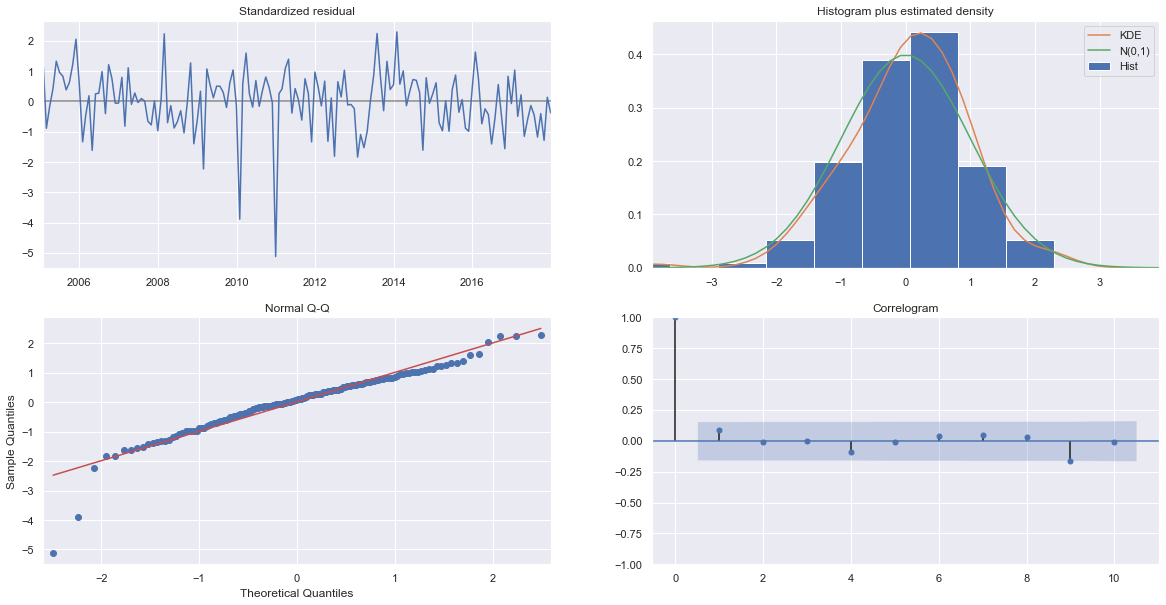

In [127]:
# parameters 
mod = sm.tsa.statespace.SARIMAX(Acc_dt_res,
                               order = (1,0,1),
                               seasonal_order = (1,0,1,12),
                               enforce_stationarity = True,
                               enforce_invertibility = True)
results = mod.fit()
print("Best model summary :")
print(results.summary().tables[1])
# diagnostics plot
print("\nResidual Analysis\n")
results.plot_diagnostics(figsize = (20,10))
plt.show()

In [128]:
# final_residuals = results.resid
# plot_pacf(final_residuals, lags = 50)
test_stationarity(results.resid)
print("\nFrom the p-value of the test, we conclude that it is stationary.\n")



Results of Dickey-Fuller test :
Test Statistic                  -3.757041
p-value                          0.003379
#Lags Used                      11.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64

From the p-value of the test, we conclude that it is stationary.



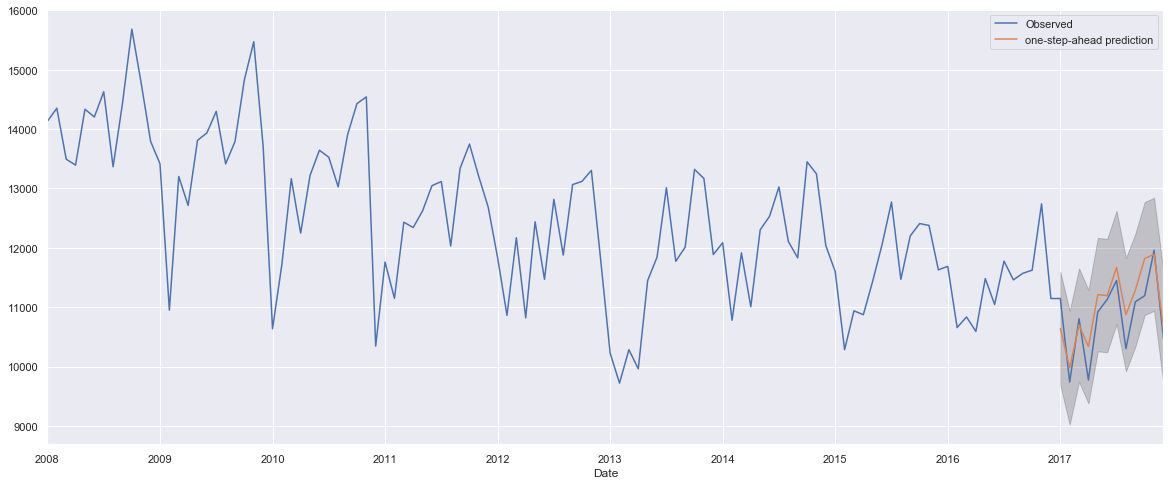

In [129]:
# doing one-step ahead prediction
# prediction for last 12 months
prediction = results.get_prediction(start = pd.to_datetime('2017-01-31'), dynamic = False)
plt.figure(figsize = (20,8))
ax = Acc_dt['2008':].plot(label = 'Observed')
res = prediction.predicted_mean*cubic[-12:]
res.plot(ax = ax, label = 'one-step-ahead prediction')
pred_ci = prediction.conf_int()
ax.fill_between(pred_ci.index,
               pred_ci.ix[:,0]*cubic[-12:],
               pred_ci.ix[:,1]*cubic[-12:],
               color = 'k', alpha = 0.2)
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# performance metric

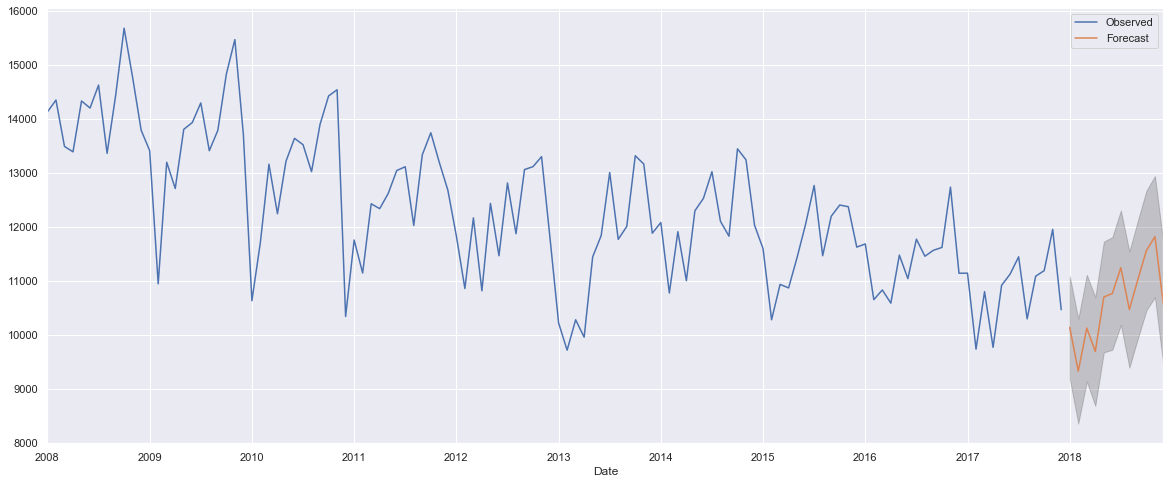

In [130]:
# forecasting for the next 12 months
future_pred_swk = results.get_forecast(steps = 12)
fut_tr = poly3.transform(np.arange(len(Acc_dt),len(Acc_dt)+12).reshape(-1,1))
future_pred_trend = cub_trend.predict(fut_tr)
fut_pr_swk_ci = future_pred_swk.conf_int()

plt.figure(figsize = (20,8))
ax = Acc_dt['2008':].plot(label = 'Observed')
fut_pred = future_pred_swk.predicted_mean*future_pred_trend
fut_pred.plot(ax = ax, label = 'Forecast')
ax.fill_between(fut_pr_swk_ci.index,
               fut_pr_swk_ci.ix[:,0]*future_pred_trend,
               fut_pr_swk_ci.ix[:,1]*future_pred_trend,
               color = 'k', alpha = 0.2)
plt.xlabel('Date')
plt.legend()
plt.show()